**Jérémy Olivier**

In [1]:
import numpy as np
import pandas as pd
import math
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statistics as st
from math import *
from sklearn.preprocessing import MinMaxScaler # Normalization
from sklearn.linear_model import LinearRegression # Regression linear model
from sklearn.model_selection import train_test_split # Splitting the data set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Metrics for errors
from sklearn.model_selection import KFold # Cross validation
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn import metrics
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import tensorflow as tf

filepath = "C:/Users/Jérémy Olivier/Documents/Université/Master/2 semester/Advanced programming/Project/"

In [4]:
!jupyter --version

jupyter core     : 4.7.1
jupyter-notebook : 6.3.0
qtconsole        : 5.0.3
ipython          : 7.22.0
ipykernel        : 5.3.4
jupyter client   : 6.1.12
jupyter lab      : 3.0.14
nbconvert        : 6.0.7
ipywidgets       : 7.6.3
nbformat         : 5.1.3
traitlets        : 5.0.5


Download dataset

In [2]:
btc = pd.read_csv(filepath + "BTC-USD.csv")
btc.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200


EDA

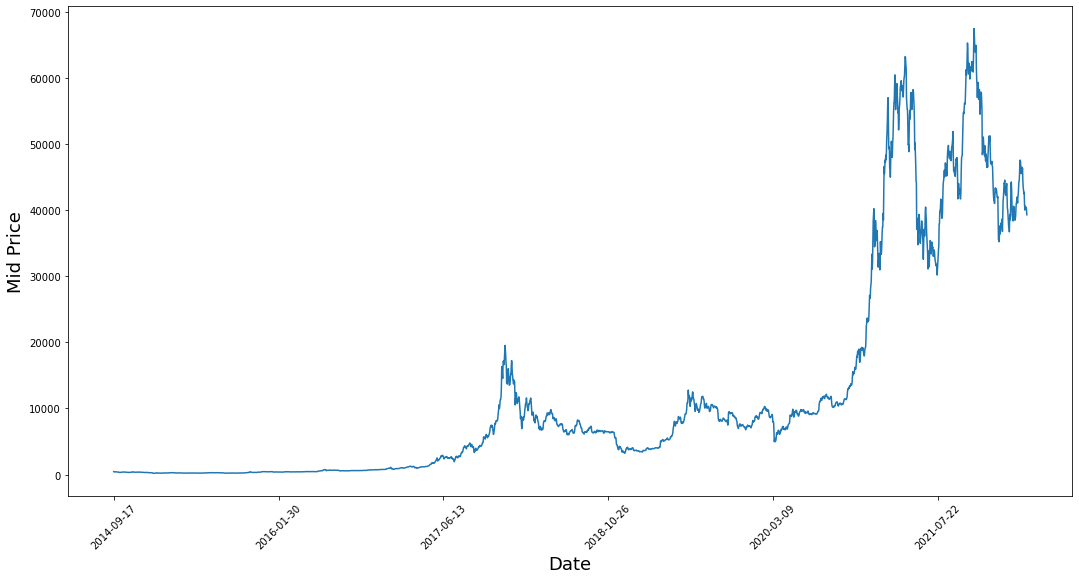

In [3]:
plt.figure(figsize = (18,9))
plt.plot(range(btc.shape[0]),(btc['Low']+btc['High'])/2.0)
plt.xticks(range(0,btc.shape[0],500),btc['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

Creation of new variables

In [4]:
#NEW BITCOIN VARIABLES
#btc["Mid"] = (btc["Open"] + btc["Low"]) / 2 #Mid price
#btc['SMA_7_Price'] = btc.iloc[:,1].rolling(window=7).mean() 
#btc['SMA_14_Price'] = btc.iloc[:,1].rolling(window=14).mean()
#btc['SMA_21_Price'] = btc.iloc[:,1].rolling(window=21).mean()
#btc['SMA_7_Volume'] = btc["Volume"].rolling(window=7).mean() 
#btc['SMA_14_Volume'] = btc["Volume"].rolling(window=14).mean()
#btc['SMA_21_Volume'] = btc["Volume"].rolling(window=21).mean()

btc["_1_Day_Vol"] = btc['Volume'].shift(periods = 1) #Volume of the day before
btc["_1_Day_Vol_Diff"] = btc["Volume"] - btc["_1_Day_Vol"] #Difference between the price T-1 and T0
btc["_1_Day_Vol_Diff_Percent"] = btc["_1_Day_Vol_Diff"] / btc["_1_Day_Vol"] #Difference between the Volume T-1 and T0 in Percent
btc['SMA_7_Volume'] = btc["_1_Day_Vol_Diff_Percent"].rolling(window=7).mean() 
btc['SMA_14_Volume'] = btc["_1_Day_Vol_Diff_Percent"].rolling(window=14).mean()
btc['SMA_21_Volume'] = btc["_1_Day_Vol_Diff_Percent"].rolling(window=21).mean()


    #Price
btc["1_Day_Price"] = btc['Close'].shift(periods = -1) #Price of the day after
btc["1_Day_Price_Diff"] = btc ["1_Day_Price"] - btc["Close"] #Difference between the price T0 and T1
btc["1_Day_Price_Diff_Percent"] = btc["1_Day_Price_Diff"] / btc ["Close"] #Difference between the price T0 and T1 in Percent

btc["_1_Day_Price"] = btc['Close'].shift(periods = 1) #Price of the day before
btc["_1_Day_Price_Diff"] = btc["Close"] - btc ["_1_Day_Price"] #Difference between the price T-1 and T0
btc["_1_Day_Price_Diff_Percent"] = btc["_1_Day_Price_Diff"] / btc ["_1_Day_Price"] #Difference between the price T-1 and T0 in Percent
btc['SMA_7_Price'] = btc["_1_Day_Price_Diff_Percent"].rolling(window=7).mean() 
btc['SMA_14_Price'] = btc["_1_Day_Price_Diff_Percent"].rolling(window=14).mean()
btc['SMA_21_Price'] = btc["_1_Day_Price_Diff_Percent"].rolling(window=21).mean()

for i in range(1,15):
    btc["Vol",i] = btc['_1_Day_Vol_Diff_Percent'].shift(periods = i) #old volume on 14 days
for i in range(1,15):
    btc["Price",i] = btc['_1_Day_Price_Diff_Percent'].shift(periods = i) #old price on 14 days
    


0.0023670062935205217
0.038763827030897514


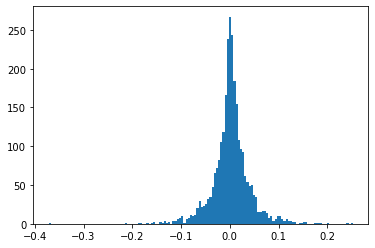

In [5]:
plt.hist(btc["1_Day_Price_Diff_Percent"], bins = "auto")
print(btc["1_Day_Price_Diff_Percent"].mean())
print(btc["1_Day_Price_Diff_Percent"].std())

<AxesSubplot:xlabel='1_Day_Price_Diff_Percent'>

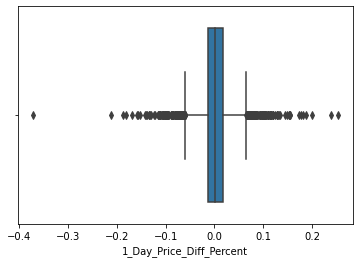

In [6]:
sns.boxplot(x = btc["1_Day_Price_Diff_Percent"])

array([[<AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'High'}>,
        <AxesSubplot:title={'center':'Low'}>,
        <AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'Adj Close'}>,
        <AxesSubplot:title={'center':'Volume'}>,
        <AxesSubplot:title={'center':'_1_Day_Vol'}>],
       [<AxesSubplot:title={'center':'_1_Day_Vol_Diff'}>,
        <AxesSubplot:title={'center':'_1_Day_Vol_Diff_Percent'}>,
        <AxesSubplot:title={'center':'SMA_7_Volume'}>,
        <AxesSubplot:title={'center':'SMA_14_Volume'}>,
        <AxesSubplot:title={'center':'SMA_21_Volume'}>,
        <AxesSubplot:title={'center':'1_Day_Price'}>,
        <AxesSubplot:title={'center':'1_Day_Price_Diff'}>],
       [<AxesSubplot:title={'center':'1_Day_Price_Diff_Percent'}>,
        <AxesSubplot:title={'center':'_1_Day_Price'}>,
        <AxesSubplot:title={'center':'_1_Day_Price_Diff'}>,
        <AxesSubplot:title={'center':'_1_Day_Price_Diff_Percent'}>,
  

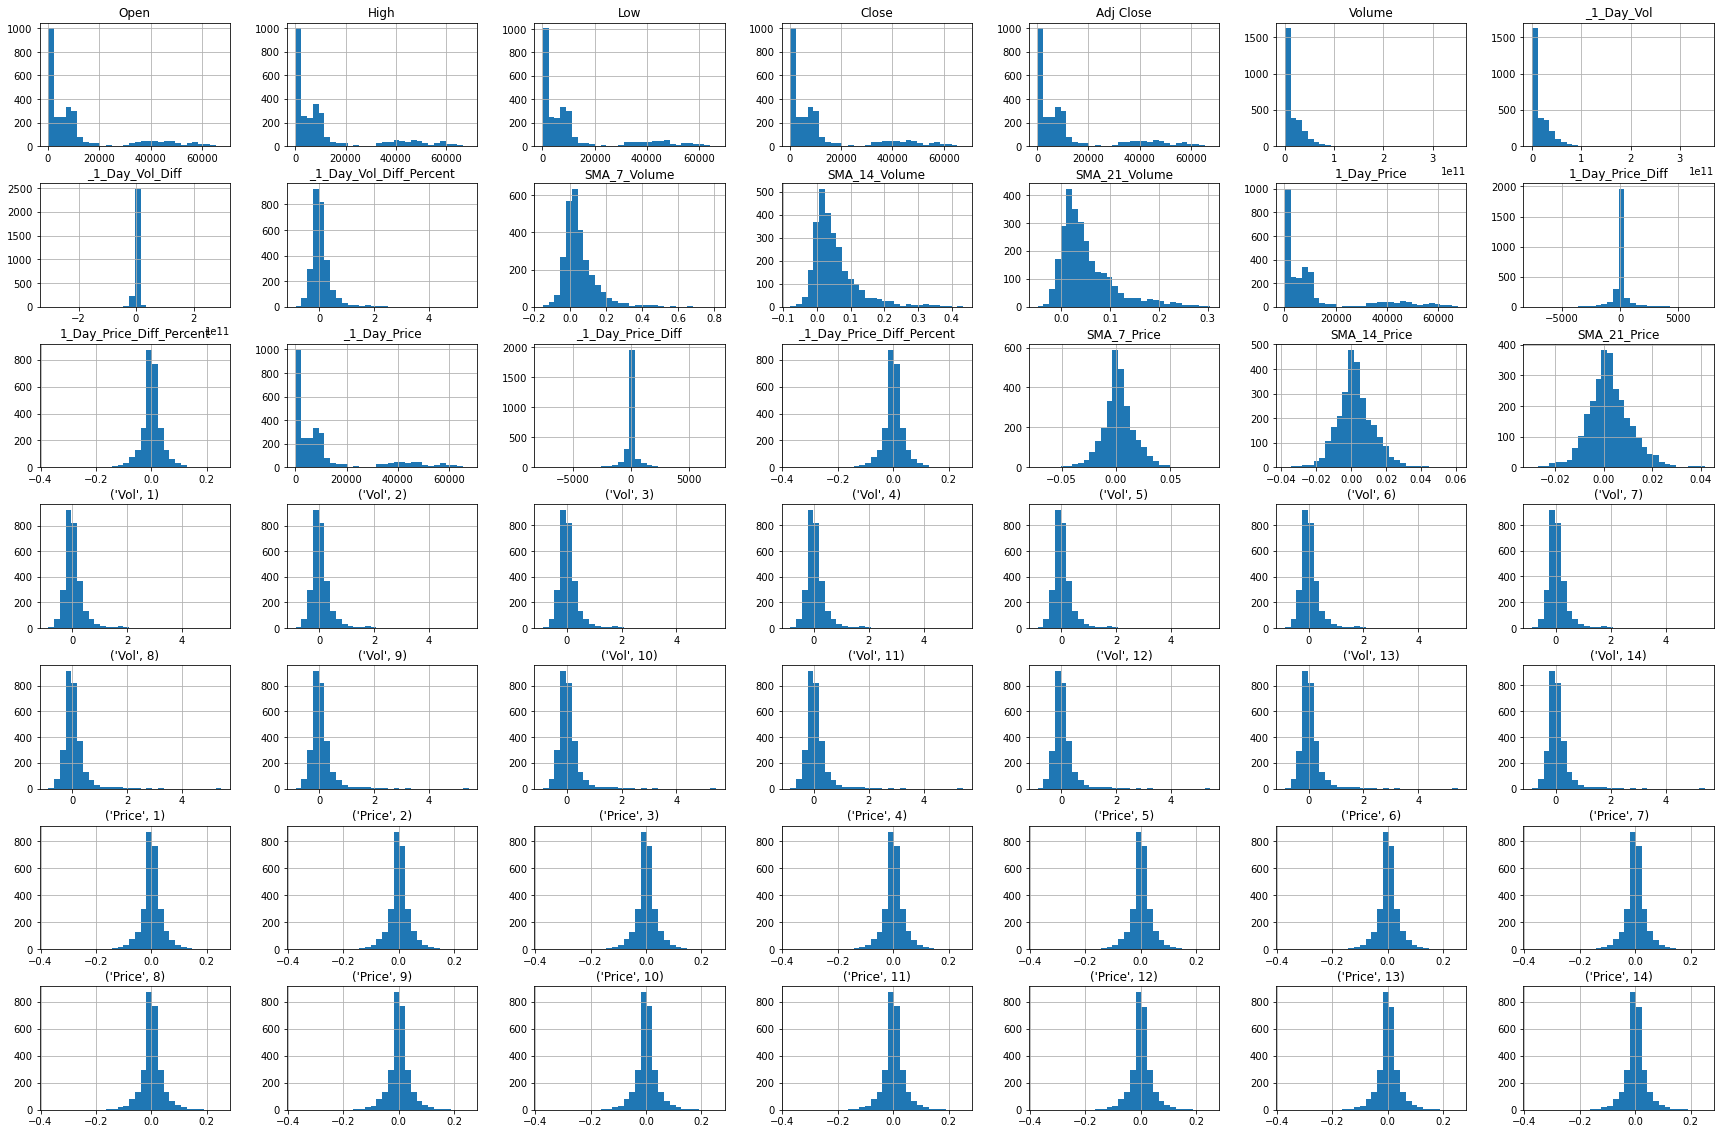

In [7]:
#histogram
btc.hist(bins=30, figsize=(30, 20))

Naive Model

In [8]:
def rmse_(y_true, y_pred):
    MSE = np.square(np.subtract(y_true,y_pred)).mean() 
    RMSE = math.sqrt(MSE)
    print("RMSE :" , RMSE)

In [9]:
rmse_(btc["1_Day_Price_Diff_Percent"][1500:1875], btc["_1_Day_Price_Diff_Percent"][1500:1875])

RMSE : 0.05554763910128054


In [10]:
rmse_(btc["1_Day_Price"][1500:1875], btc["Close"][1500:1875])

RMSE : 314.4776166034977


Pred = 0

In [11]:
math.sqrt(btc["1_Day_Price_Diff_Percent"][1500:1875].mean())

0.04149486771590367

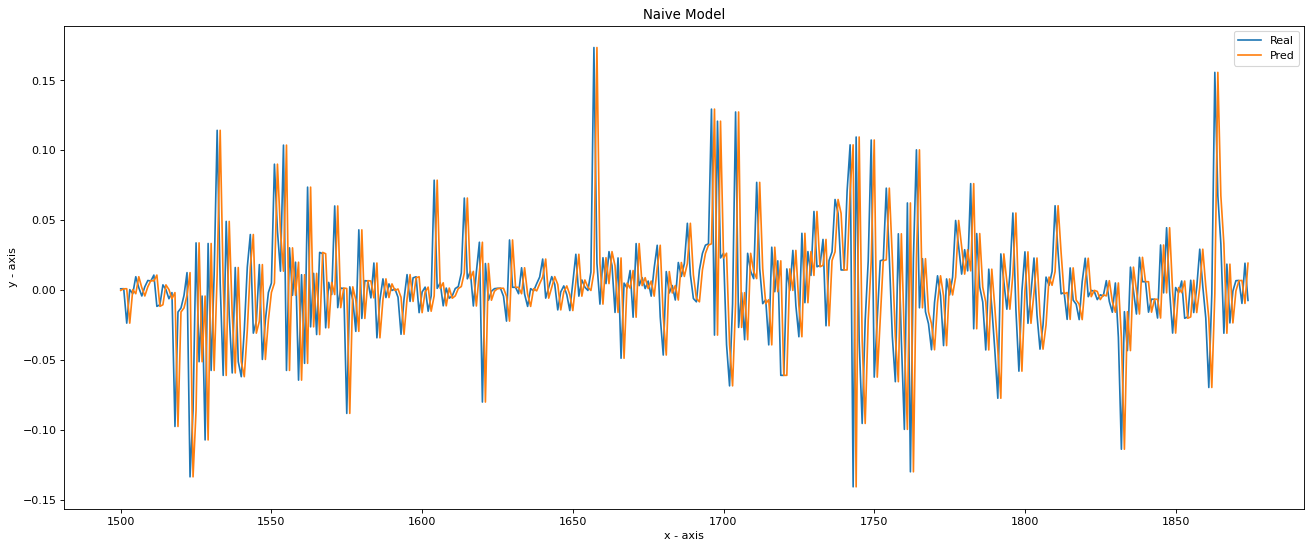

In [12]:
from matplotlib.pyplot import figure

figure(figsize=(20,8), dpi=80)

l = []
for i in range(1500,1875):
    l.append(i)
l

plt.plot(l, btc["1_Day_Price_Diff_Percent"][1500:1875].values, label = "Real")
plt.plot(l, btc["_1_Day_Price_Diff_Percent"][1500:1875], label = "Pred")

plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Naive Model')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

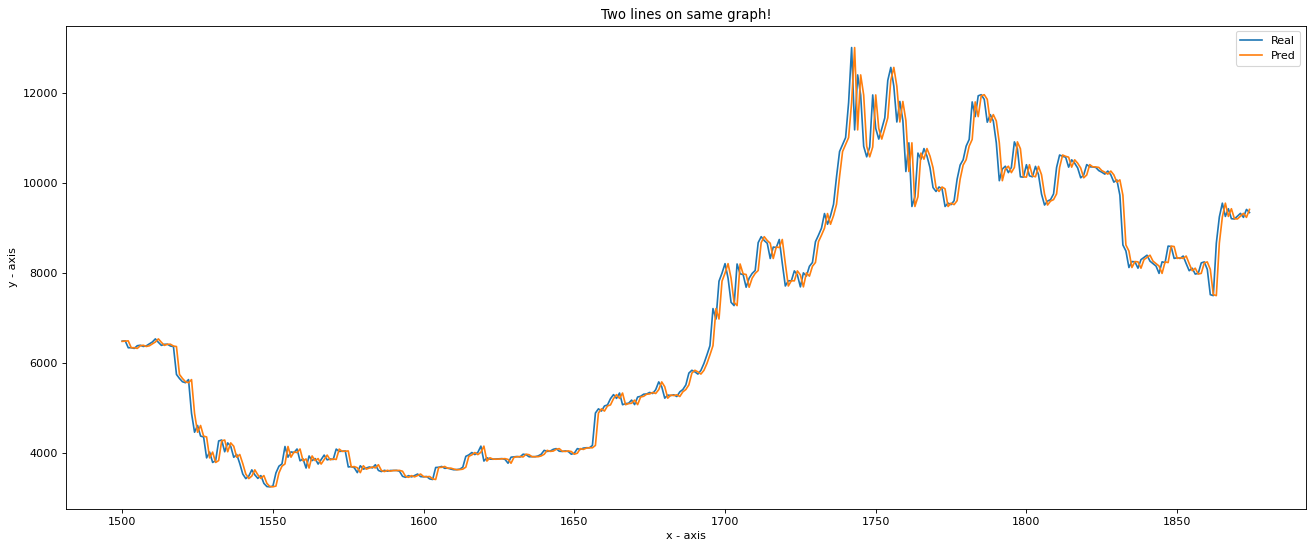

In [13]:
from matplotlib.pyplot import figure

figure(figsize=(20,8), dpi=80)

l = []
for i in range(1500,1875):
    l.append(i)
l

plt.plot(l, btc["1_Day_Price"][1500:1875].values, label = "Real")
plt.plot(l, btc["Close"][1500:1875], label = "Pred")

plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Two lines on same graph!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

DNN Model

In [14]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb

In [15]:
#error is normal
%load_ext tensorboard
import tensorflow as tf
import datetime, os
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

In [16]:
no_features = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '1_Day_Price', '1_Day_Price_Diff', '1_Day_Price_Diff_Percent','_1_Day_Price', '_1_Day_Price_Diff', '_1_Day_Vol', '_1_Day_Vol_Diff']
x_train = btc.drop(no_features, 1)


import random
random.seed(2022)
tf.random.set_seed(2022)
initializer = tf.keras.initializers.HeNormal(seed=2022)
def pythonash_model():
    inputs_ = tf.keras.Input(shape = [x_train.shape[1]])
    x = tf.keras.layers.Dense(32, kernel_initializer = initializer)(inputs_)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(32, kernel_initializer = initializer)(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(64, kernel_initializer = initializer)(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)

    x = tf.keras.layers.Dense(64, kernel_initializer = initializer)(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(32, kernel_initializer = initializer)(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    drop = tf.keras.layers.Dropout(0.1)(leaky) #Dropout to avoid overfitting
    
    x = tf.keras.layers.Dense(32, kernel_initializer = initializer)(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(16, kernel_initializer = initializer)(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    drop = tf.keras.layers.Dropout(0.1)(leaky) #Dropout to avoid overfitting
    
    x = tf.keras.layers.Dense(8, kernel_initializer = initializer)(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    drop = tf.keras.layers.Dropout(0.1)(leaky) #Dropout to avoid overfitting
    
    outputs_ = tf.keras.layers.Dense(1)(drop)
    
    model = tf.keras.Model(inputs = inputs_, outputs = outputs_)
    
    rmse = tf.keras.metrics.RootMeanSquaredError()

    learning_sch = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0015,
    decay_steps = 1500,
    decay_rate = 0.95)
    adam = tf.keras.optimizers.Adam(learning_rate = learning_sch)
    
    model.compile(loss = 'mse', metrics = [rmse,], optimizer = adam) #adam optimizer!!
    return model

#pythonash_model().summary()

In [17]:
import graphviz
import pydot
tf.keras.utils.plot_model(pythonash_model())

#already intsall ... cound't fix the issue

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [18]:
df_x = btc.drop(no_features, axis=1)[25:1500]
df_y = btc["1_Day_Price_Diff_Percent"][25:1500]

test_x = btc.drop(no_features, axis=1)[1500:1875]
test_y = btc["1_Day_Price_Diff_Percent"][1500:1875]

In [19]:
kfold_generator = KFold(n_splits =10, shuffle=True, random_state = 2000)
kfold_generator

KFold(n_splits=10, random_state=2000, shuffle=True)

In [20]:
#Final model
# WModel save
from datetime import datetime
#callbacks = tf.keras.callbacks.ModelCheckpoint(filepath + "M1", save_best_only = True)
for train_index, val_index in kfold_generator.split(df_x, df_y):
    # Split training dataset.
    train_x, train_y = df_x.iloc[train_index], df_y.iloc[train_index]
    # Split validation dataset.
    val_x, val_y = df_x.iloc[val_index], df_y.iloc[val_index]
    # Make tensor dataset.
    ##tf_train = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(2022).batch(500, drop_remainder=True).prefetch(1)
    ##tf_val = tf.data.Dataset.from_tensor_slices((val_x, val_y)).shuffle(2022).batch(1024, drop_remainder=True).prefetch(1)
    # Load model
    model = pythonash_model()
    # Model fitting
    logdir = os.path.join(logs_base_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=25)
    
    model1 = model.fit(train_x, train_y, batch_size=64, epochs = 25, ### change the epochs into more numbers.
             validation_data = (val_x, val_y), shuffle=True, callbacks=[tensorboard_callback])
    # Delete tensor dataset and model to save memory
    del model
    ##del tf_train
    ##del tf_val
    
    
#best_model = tf.keras.models.load_model(filepath + "M1")   
#pred1 = best_model.predict(test_x)

Epoch 1/25
21/21 [==============================] - 3s 27ms/step - loss: 0.3519 - root_mean_squared_error: 0.5932 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0713
Epoch 2/25
21/21 [==============================] - 0s 5ms/step - loss: 0.1085 - root_mean_squared_error: 0.3293 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0752
Epoch 3/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0479 - root_mean_squared_error: 0.2188 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1018
Epoch 4/25
21/21 [==============================] - 0s 6ms/step - loss: 0.0317 - root_mean_squared_error: 0.1780 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 5/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0274 - root_mean_squared_error: 0.1654 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 6/25
21/21 [==============================] - 0s 6ms/step - loss: 0.0222 - root_mean_squared_error: 0.1489 - val_loss: 0.0070 - val_root_mean_s

21/21 [==============================] - 0s 4ms/step - loss: 0.0242 - root_mean_squared_error: 0.1557 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0705
Epoch 25/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0218 - root_mean_squared_error: 0.1475 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0696
Epoch 1/25
21/21 [==============================] - 3s 26ms/step - loss: 0.3724 - root_mean_squared_error: 0.6102 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2237
Epoch 2/25
21/21 [==============================] - 0s 3ms/step - loss: 0.1388 - root_mean_squared_error: 0.3726 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1260
Epoch 3/25
21/21 [==============================] - 0s 3ms/step - loss: 0.1002 - root_mean_squared_error: 0.3166 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 4/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0917 - root_mean_squared_error: 0.3029 - val_loss: 0.0131 - val_root_mean_squared_err

21/21 [==============================] - 0s 5ms/step - loss: 0.0106 - root_mean_squared_error: 0.1031 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0647
Epoch 21/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0655
Epoch 22/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591
Epoch 23/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588
Epoch 24/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 25/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0035 - val_root_mean_squared_

Epoch 16/25
21/21 [==============================] - 0s 8ms/step - loss: 0.0088 - root_mean_squared_error: 0.0940 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581
Epoch 17/25
21/21 [==============================] - 0s 8ms/step - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 18/25
21/21 [==============================] - 0s 7ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0542
Epoch 19/25
21/21 [==============================] - 0s 8ms/step - loss: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0534
Epoch 20/25
21/21 [==============================] - 0s 10ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0531
Epoch 21/25
21/21 [==============================] - 0s 8ms/step - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0028 - val_root_

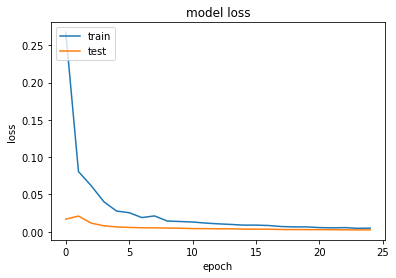

In [21]:
# summarize history for loss
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 17244), started 4:19:01 ago. (Use '!kill 17244' to kill it.)

In [23]:
#Final model
# WModel save
callbacks = tf.keras.callbacks.ModelCheckpoint(filepath + "M1", save_best_only = True)
for train_index, val_index in kfold_generator.split(df_x, df_y):
    # Split training dataset.
    train_x, train_y = df_x.iloc[train_index], df_y.iloc[train_index]
    # Split validation dataset.
    val_x, val_y = df_x.iloc[val_index], df_y.iloc[val_index]
    # Make tensor dataset.
    ##tf_train = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(2022).batch(500, drop_remainder=True).prefetch(1)
    ##tf_val = tf.data.Dataset.from_tensor_slices((val_x, val_y)).shuffle(2022).batch(1024, drop_remainder=True).prefetch(1)
    # Load model
    model = pythonash_model()
    # Model fitting
    
    model1 = model.fit(train_x, train_y, callbacks = callbacks, batch_size=64, epochs = 12, ### change the epochs into more numbers.
             validation_data = (val_x, val_y), shuffle=True)
    # Delete tensor dataset and model to save memory
    del model
    ##del tf_train
    ##del tf_val
    
best_model = tf.keras.models.load_model(filepath + "M1")   
pred1 = best_model.predict(test_x)

Epoch 1/12
21/21 [==============================] - 6s 217ms/step - loss: 0.4274 - root_mean_squared_error: 0.6537 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2034
Epoch 2/12
21/21 [==============================] - 3s 155ms/step - loss: 0.1779 - root_mean_squared_error: 0.4218 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1579
Epoch 3/12
21/21 [==============================] - 4s 180ms/step - loss: 0.0839 - root_mean_squared_error: 0.2896 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1129
Epoch 4/12
21/21 [==============================] - 3s 165ms/step - loss: 0.0673 - root_mean_squared_error: 0.2593 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1056
Epoch 5/12
21/21 [==============================] - 3s 169ms/step - loss: 0.0679 - root_mean_squared_error: 0.2606 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1034
Epoch 6/12
21/21 [==============================] - 3s 148ms/step - loss: 0.0711 - root_mean_squared_error: 0.2667 - val_loss: 0.0103 - val_

Epoch 6/12
21/21 [==============================] - 4s 196ms/step - loss: 0.0293 - root_mean_squared_error: 0.1710 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616
Epoch 7/12
21/21 [==============================] - 3s 168ms/step - loss: 0.0223 - root_mean_squared_error: 0.1492 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611
Epoch 8/12
21/21 [==============================] - 4s 183ms/step - loss: 0.0208 - root_mean_squared_error: 0.1444 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589
Epoch 9/12
21/21 [==============================] - 0s 4ms/step - loss: 0.0223 - root_mean_squared_error: 0.1493 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 10/12
21/21 [==============================] - 3s 171ms/step - loss: 0.0152 - root_mean_squared_error: 0.1232 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 11/12
21/21 [==============================] - 4s 201ms/step - loss: 0.0137 - root_mean_squared_error: 0.1170 - val_loss: 0.0030 - val_

Epoch 10/12
21/21 [==============================] - 0s 4ms/step - loss: 0.0415 - root_mean_squared_error: 0.2037 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1490
Epoch 11/12
21/21 [==============================] - 0s 4ms/step - loss: 0.0359 - root_mean_squared_error: 0.1896 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1278
Epoch 12/12
21/21 [==============================] - 0s 4ms/step - loss: 0.0339 - root_mean_squared_error: 0.1840 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1264
Epoch 1/12
21/21 [==============================] - 2s 18ms/step - loss: 0.7923 - root_mean_squared_error: 0.8901 - val_loss: 0.0778 - val_root_mean_squared_error: 0.2790
Epoch 2/12
21/21 [==============================] - 0s 4ms/step - loss: 0.3002 - root_mean_squared_error: 0.5479 - val_loss: 0.0451 - val_root_mean_squared_error: 0.2124
Epoch 3/12
21/21 [==============================] - 0s 4ms/step - loss: 0.2397 - root_mean_squared_error: 0.4896 - val_loss: 0.0395 - val_root_mea

Epoch 9/12
21/21 [==============================] - 0s 4ms/step - loss: 0.0403 - root_mean_squared_error: 0.2006 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0905
Epoch 10/12
21/21 [==============================] - 0s 4ms/step - loss: 0.0366 - root_mean_squared_error: 0.1914 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0872
Epoch 11/12
21/21 [==============================] - 0s 4ms/step - loss: 0.0357 - root_mean_squared_error: 0.1890 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 12/12
21/21 [==============================] - 0s 4ms/step - loss: 0.0322 - root_mean_squared_error: 0.1793 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0969


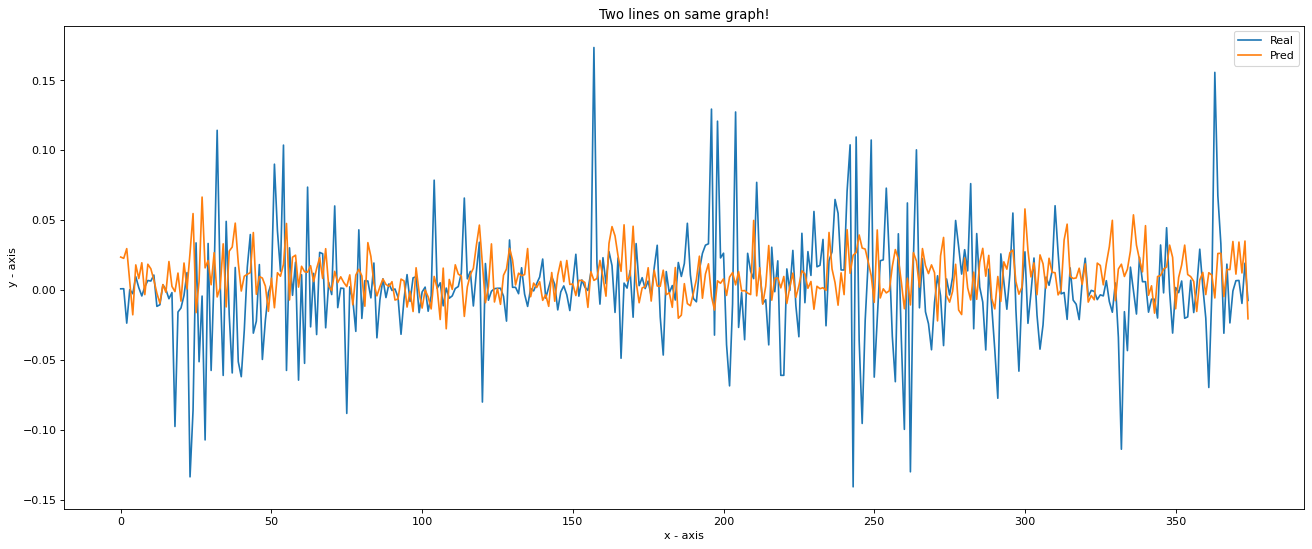

RMSE : 0.04245313420719013


In [24]:
from matplotlib.pyplot import figure

figure(figsize=(20,8), dpi=80)

plt.plot(btc["1_Day_Price_Diff_Percent"][1500:1875].values, label = "Real")
plt.plot(pred1, label = "Pred")

plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Two lines on same graph!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()
rmse_(btc["1_Day_Price_Diff_Percent"][1500:1875].values,pred1)

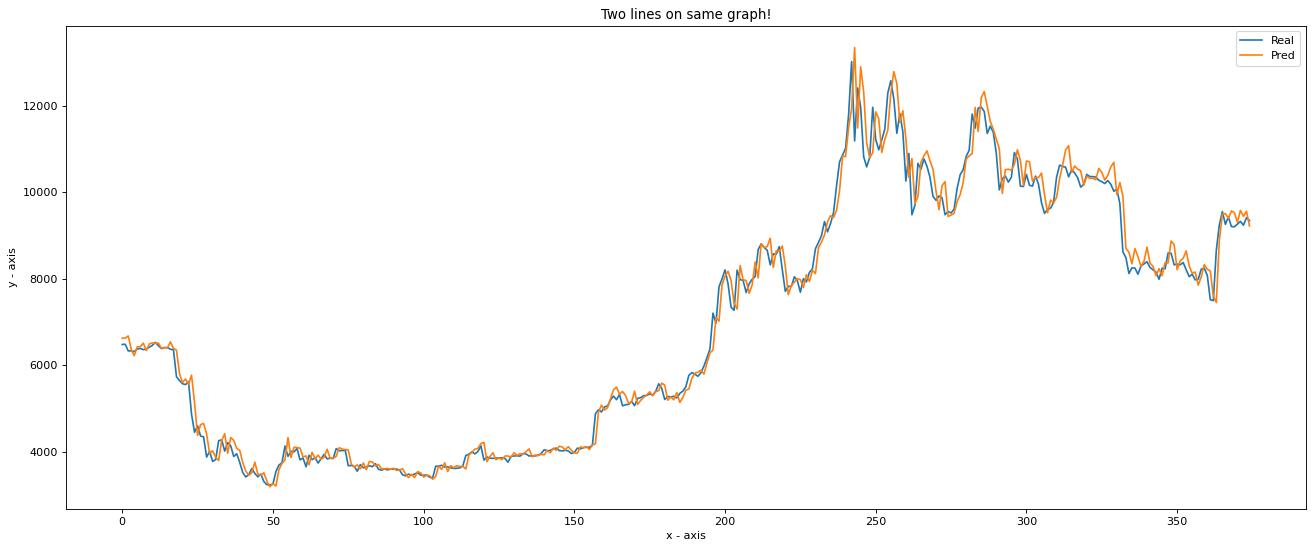

RMSE : 4016.229496277509


In [25]:
figure(figsize=(20,8), dpi=80)

pred_price = []
for num1, num2 in zip(pred1, btc["Close"][1500:1875].values):
	pred_price.append((num1 * num2) + num2)

plt.plot(btc["1_Day_Price"][1500:1875].values, label = "Real")
plt.plot(pred_price, label = "Pred")

plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Two lines on same graph!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()
rmse_(btc["1_Day_Price"][1500:1875].values,pred_price)

**Twitter**

Dowload data

In [26]:
tweet = pd.read_csv("C:/Users/Jérémy Olivier/Documents/Université/Master/2 semester/Advanced programming/Project/tweet_compound.csv")
tweet.head(2)

,Unnamed: 0,id,user,fullname,Date,replies,likes,retweets,text,compound
0,11291156,3.286741e+07,chrispychong,chrispy,2007-04-19 07:14:38+00,0,0,2,is happily mugging at BTC where she will hook ...,0.8516
1,21,1.110303e+09,halfin,halfin,2009-01-11 03:33:52+00,790,14470,5542,Running bitcoin\r,0.0000


In [27]:
#Date
tweet['Date'] = pd.to_datetime(tweet['Date']).dt.strftime('%Y-%m-%d')
tweet.index = tweet['Date']
tweet.index.names = ['date']
tweet = tweet.sort_values(by = 'Date')

In [28]:

tweet.groupby(['Date']).mean().reset_index()

tt =tweet.groupby(['Date']).sum().reset_index()
tt.rename(columns={'likes':'tot_likes'}, inplace=True)

tweet["score"] = (tweet["compound"] * tweet["likes"])
tweet_compound = tweet.groupby(['Date']).sum().reset_index()
tweet_compound["score"] = tweet_compound["score"] / tt["tot_likes"]


tweet_count = tweet.groupby(['Date']).size().reset_index(name='counts')

In [29]:
tweet_count["_1_counts"] = tweet_count['counts'].shift(periods = 1) #counts of the day before
tweet_count["_1_counts_diff"] = tweet_count["counts"] - tweet_count["_1_counts"] #Difference between the counts T-1 and T0
tweet_count["_1_counts_diff_percent"] = tweet_count["_1_counts_diff"] / tweet_count["_1_counts"] #Difference between the counts T-1 and T0 in Percent
tweet_count['SMA_7_counts'] = tweet_count["_1_counts_diff_percent"].rolling(window=7).mean() 
tweet_count['SMA_14_counts'] = tweet_count["_1_counts_diff_percent"].rolling(window=14).mean()
tweet_count['SMA_21_counts'] = tweet_count["_1_counts_diff_percent"].rolling(window=21).mean()
for i in range(1,15):
    tweet_count["counts",i] = tweet_count['_1_counts_diff_percent'].shift(periods = i) #old volume on 14 days

tweet_compound["score"] = tweet_compound["score"] + 1
tweet_compound["_1_score"] = tweet_compound["score"].shift(periods = 1) #counts of the day before
tweet_compound["_1_score_diff"] = tweet_compound["score"] - tweet_compound["_1_score"] #Difference between the counts T-1 and T0
tweet_compound["_1_score_diff_percent"] = tweet_compound["_1_score_diff"] / tweet_compound["_1_score"] #Difference between the counts T-1 and T0 in Percent
tweet_compound['SMA_7_score'] = tweet_compound["_1_score_diff_percent"].rolling(window=7).mean() 
tweet_compound['SMA_14_score'] = tweet_compound["_1_score_diff_percent"].rolling(window=14).mean()
tweet_compound['SMA_21_score'] = tweet_compound["_1_score_diff_percent"].rolling(window=21).mean()
for i in range(1,15):
    tweet_compound["score",i] = tweet_compound['_1_score_diff_percent'].shift(periods = i) #old volume on 14 days

In [30]:
df = btc.merge(tweet_count, how = 'inner', on='Date')
df = df.merge(tweet_compound, how = 'inner', on='Date')

In [31]:
no_features = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '1_Day_Price', '1_Day_Price_Diff', 
               '1_Day_Price_Diff_Percent','_1_Day_Price', '_1_Day_Price_Diff', '_1_Day_Vol', '_1_Day_Vol_Diff' , 'id', 
               'replies','likes','retweets','compound', 'score', '_1_score', '_1_score_diff', '_1_score_diff_percent', 
                'counts', '_1_counts', '_1_counts_diff','_1_counts_diff_percent']
df_test = df.drop(no_features, 1)

array([[<AxesSubplot:title={'center':'_1_Day_Vol_Diff_Percent'}>,
        <AxesSubplot:title={'center':'SMA_7_Volume'}>,
        <AxesSubplot:title={'center':'SMA_14_Volume'}>,
        <AxesSubplot:title={'center':'SMA_21_Volume'}>,
        <AxesSubplot:title={'center':'_1_Day_Price_Diff_Percent'}>,
        <AxesSubplot:title={'center':'SMA_7_Price'}>,
        <AxesSubplot:title={'center':'SMA_14_Price'}>,
        <AxesSubplot:title={'center':'SMA_21_Price'}>],
       [<AxesSubplot:title={'center':"('Vol', 1)"}>,
        <AxesSubplot:title={'center':"('Vol', 2)"}>,
        <AxesSubplot:title={'center':"('Vol', 3)"}>,
        <AxesSubplot:title={'center':"('Vol', 4)"}>,
        <AxesSubplot:title={'center':"('Vol', 5)"}>,
        <AxesSubplot:title={'center':"('Vol', 6)"}>,
        <AxesSubplot:title={'center':"('Vol', 7)"}>,
        <AxesSubplot:title={'center':"('Vol', 8)"}>],
       [<AxesSubplot:title={'center':"('Vol', 9)"}>,
        <AxesSubplot:title={'center':"('Vol', 10)"}>,
  

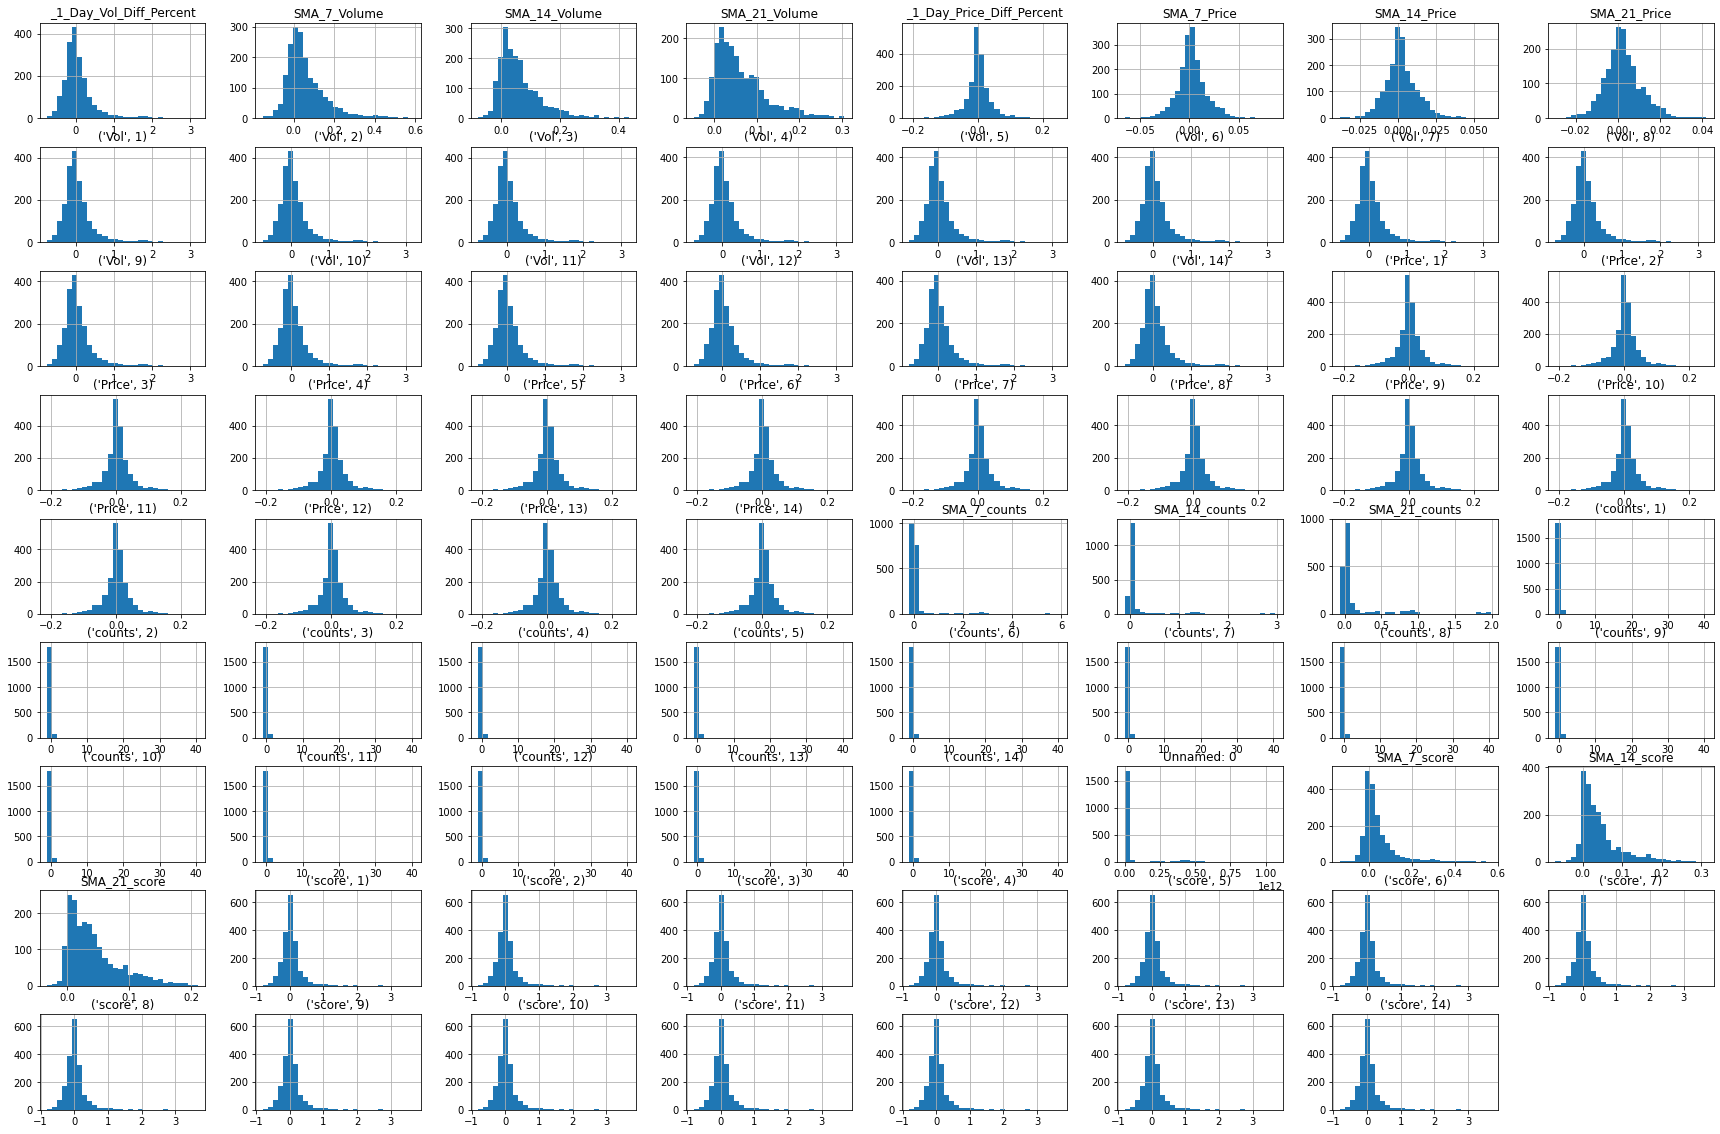

In [32]:
df_test.hist(bins=30, figsize=(30, 20))

In [33]:
no_features = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '1_Day_Price', '1_Day_Price_Diff', 
               '1_Day_Price_Diff_Percent','_1_Day_Price', '_1_Day_Price_Diff', '_1_Day_Vol', '_1_Day_Vol_Diff' , 'id', 
               'replies','likes','retweets','compound', 'score', '_1_score', '_1_score_diff', '_1_score_diff_percent', 
                'counts', '_1_counts', '_1_counts_diff','_1_counts_diff_percent']
x_train = df.drop(no_features, 1)


import random
random.seed(2022)
tf.random.set_seed(2022)
initializer = tf.keras.initializers.HeNormal(seed=2022)
def pythonash_model():
    inputs_ = tf.keras.Input(shape = [x_train.shape[1]])
    x = tf.keras.layers.Dense(32, kernel_initializer = initializer)(inputs_)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(32, kernel_initializer = initializer)(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(64, kernel_initializer = initializer)(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)

    x = tf.keras.layers.Dense(64, kernel_initializer = initializer)(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(32, kernel_initializer = initializer)(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    drop = tf.keras.layers.Dropout(0.1)(leaky) #Dropout to avoid overfitting
    
    x = tf.keras.layers.Dense(32, kernel_initializer = initializer)(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(16, kernel_initializer = initializer)(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    drop = tf.keras.layers.Dropout(0.1)(leaky) #Dropout to avoid overfitting
    
    x = tf.keras.layers.Dense(8, kernel_initializer = initializer)(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    drop = tf.keras.layers.Dropout(0.1)(leaky) #Dropout to avoid overfitting
    
    outputs_ = tf.keras.layers.Dense(1)(drop)
    
    model = tf.keras.Model(inputs = inputs_, outputs = outputs_)
    
    rmse = tf.keras.metrics.RootMeanSquaredError()

    learning_sch = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0015,
    decay_steps = 1500,
    decay_rate = 0.95)
    adam = tf.keras.optimizers.Adam(learning_rate = learning_sch)
    
    model.compile(loss = 'mse', metrics = [rmse,], optimizer = adam) #adam optimizer!!
    return model

#pythonash_model().summary()

In [34]:
import graphviz
import pydot
tf.keras.utils.plot_model(pythonash_model(),show_shapes=True,expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [35]:
from sklearn.preprocessing import StandardScaler
df_x = df.drop(no_features, axis=1)[25:1500]
df_y = df["1_Day_Price_Diff_Percent"][25:1500]

test_x = df.drop(no_features, axis=1)[1500:1875]
test_y = df["1_Day_Price_Diff_Percent"][1500:1875]

#scale data because of vriable of score
scaler = StandardScaler()
df_x = pd.DataFrame(scaler.fit_transform(df_x))
test_x = pd.DataFrame(scaler.transform(test_x))

In [36]:
kfold_generator = KFold(n_splits =10, shuffle=True, random_state = 2022)
kfold_generator

KFold(n_splits=10, random_state=2022, shuffle=True)

In [37]:
# Final model
# WModel save
#callbacks = tf.keras.callbacks.ModelCheckpoint(filepath + "M2", save_best_only = True)
for train_index, val_index in kfold_generator.split(df_x, df_y):
    # Split training dataset.
    train_x, train_y = df_x.iloc[train_index], df_y.iloc[train_index]
    # Split validation dataset.
    val_x, val_y = df_x.iloc[val_index], df_y.iloc[val_index]
    # Make tensor dataset.
    ##tf_train = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(2022).batch(500, drop_remainder=True).prefetch(1)
    ##tf_val = tf.data.Dataset.from_tensor_slices((val_x, val_y)).shuffle(2022).batch(1024, drop_remainder=True).prefetch(1)
    # Load model
    model = pythonash_model()
    # Model fitting
    logdir = os.path.join(logs_base_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=25)
    model2 = model.fit(train_x, train_y, callbacks = tensorboard_callback, batch_size=64, epochs = 25, ### change the epochs into more numbers.
             validation_data = (val_x, val_y), shuffle=True)
    # Delete tensor dataset and model to save memory
    del model
    ##del tf_train
    ##del tf_val
    
#best_model = tf.keras.models.load_model(filepath + "M2")   
#pred2 = best_model.predict(test_x)

Epoch 1/25
21/21 [==============================] - 2s 28ms/step - loss: 0.3330 - root_mean_squared_error: 0.5771 - val_loss: 0.0661 - val_root_mean_squared_error: 0.2571
Epoch 2/25
21/21 [==============================] - 0s 5ms/step - loss: 0.1040 - root_mean_squared_error: 0.3225 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1822
Epoch 3/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0437 - root_mean_squared_error: 0.2090 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1749
Epoch 4/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0332 - root_mean_squared_error: 0.1821 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1328
Epoch 5/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0256 - root_mean_squared_error: 0.1601 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1319
Epoch 6/25
21/21 [==============================] - 0s 6ms/step - loss: 0.0213 - root_mean_squared_error: 0.1459 - val_loss: 0.0124 - val_root_mean_s

21/21 [==============================] - 0s 4ms/step - loss: 0.0285 - root_mean_squared_error: 0.1689 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0800
Epoch 25/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0249 - root_mean_squared_error: 0.1577 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739
Epoch 1/25
21/21 [==============================] - 2s 25ms/step - loss: 0.3808 - root_mean_squared_error: 0.6171 - val_loss: 1.0747 - val_root_mean_squared_error: 1.0367
Epoch 2/25
21/21 [==============================] - 0s 4ms/step - loss: 0.1363 - root_mean_squared_error: 0.3691 - val_loss: 0.1792 - val_root_mean_squared_error: 0.4234
Epoch 3/25
21/21 [==============================] - 0s 4ms/step - loss: 0.1085 - root_mean_squared_error: 0.3294 - val_loss: 0.1303 - val_root_mean_squared_error: 0.3609
Epoch 4/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0736 - root_mean_squared_error: 0.2713 - val_loss: 0.0750 - val_root_mean_squared_err

21/21 [==============================] - 0s 4ms/step - loss: 0.0104 - root_mean_squared_error: 0.1021 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787
Epoch 21/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0091 - root_mean_squared_error: 0.0951 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0905
Epoch 22/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0093 - root_mean_squared_error: 0.0965 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795
Epoch 23/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0755
Epoch 24/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795
Epoch 25/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0082 - root_mean_squared_error: 0.0903 - val_loss: 0.0063 - val_root_mean_squared_

21/21 [==============================] - 0s 4ms/step - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606
Epoch 17/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 18/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 19/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0534
Epoch 20/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524
Epoch 21/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0026 - val_root_mean_squared_

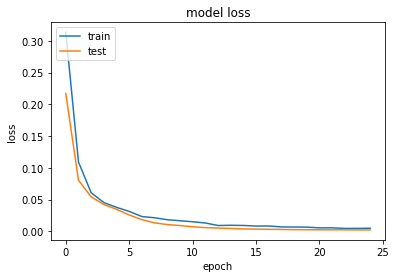

In [38]:
# summarize history for loss
plt.plot(model2.history['loss'])
plt.plot(model2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
#Final model
# WModel save
callbacks = tf.keras.callbacks.ModelCheckpoint(filepath + "M2", save_best_only = True)
for train_index, val_index in kfold_generator.split(df_x, df_y):
    # Split training dataset.
    train_x, train_y = df_x.iloc[train_index], df_y.iloc[train_index]
    # Split validation dataset.
    val_x, val_y = df_x.iloc[val_index], df_y.iloc[val_index]
    # Make tensor dataset.
    ##tf_train = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(2022).batch(500, drop_remainder=True).prefetch(1)
    ##tf_val = tf.data.Dataset.from_tensor_slices((val_x, val_y)).shuffle(2022).batch(1024, drop_remainder=True).prefetch(1)
    # Load model
    model = pythonash_model()
    # Model fitting
    
    model2 = model.fit(train_x, train_y, callbacks = callbacks, batch_size=64, epochs = 8, ### change the epochs into more numbers.
             validation_data = (val_x, val_y), shuffle=True)
    # Delete tensor dataset and model to save memory
    del model
    ##del tf_train
    ##del tf_val
    
best_model = tf.keras.models.load_model(filepath + "M2")   
pred2 = best_model.predict(test_x)

Epoch 1/8
21/21 [==============================] - 6s 192ms/step - loss: 0.4783 - root_mean_squared_error: 0.6916 - val_loss: 0.2336 - val_root_mean_squared_error: 0.4833
Epoch 2/8
21/21 [==============================] - 3s 166ms/step - loss: 0.1732 - root_mean_squared_error: 0.4162 - val_loss: 0.1280 - val_root_mean_squared_error: 0.3577
Epoch 3/8
21/21 [==============================] - 4s 181ms/step - loss: 0.1045 - root_mean_squared_error: 0.3233 - val_loss: 0.0709 - val_root_mean_squared_error: 0.2662
Epoch 4/8
21/21 [==============================] - 3s 156ms/step - loss: 0.0865 - root_mean_squared_error: 0.2941 - val_loss: 0.0478 - val_root_mean_squared_error: 0.2187
Epoch 5/8
21/21 [==============================] - 3s 165ms/step - loss: 0.0687 - root_mean_squared_error: 0.2622 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1950
Epoch 6/8
21/21 [==============================] - 3s 147ms/step - loss: 0.0605 - root_mean_squared_error: 0.2460 - val_loss: 0.0256 - val_root_m

Epoch 6/8
21/21 [==============================] - 0s 4ms/step - loss: 0.0469 - root_mean_squared_error: 0.2165 - val_loss: 0.0660 - val_root_mean_squared_error: 0.2570
Epoch 7/8
21/21 [==============================] - 0s 4ms/step - loss: 0.0404 - root_mean_squared_error: 0.2010 - val_loss: 0.0403 - val_root_mean_squared_error: 0.2008
Epoch 8/8
21/21 [==============================] - 0s 4ms/step - loss: 0.0395 - root_mean_squared_error: 0.1987 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1686
Epoch 1/8
21/21 [==============================] - 2s 16ms/step - loss: 0.6928 - root_mean_squared_error: 0.8324 - val_loss: 1.1893 - val_root_mean_squared_error: 1.0905
Epoch 2/8
21/21 [==============================] - 0s 4ms/step - loss: 0.2985 - root_mean_squared_error: 0.5463 - val_loss: 0.4757 - val_root_mean_squared_error: 0.6897
Epoch 3/8
21/21 [==============================] - 0s 3ms/step - loss: 0.1731 - root_mean_squared_error: 0.4161 - val_loss: 0.2604 - val_root_mean_squared

21/21 [==============================] - 0s 3ms/step - loss: 0.0754 - root_mean_squared_error: 0.2746 - val_loss: 0.1038 - val_root_mean_squared_error: 0.3222
Epoch 6/8
21/21 [==============================] - 0s 3ms/step - loss: 0.0737 - root_mean_squared_error: 0.2715 - val_loss: 0.1117 - val_root_mean_squared_error: 0.3342
Epoch 7/8
21/21 [==============================] - 0s 4ms/step - loss: 0.0553 - root_mean_squared_error: 0.2351 - val_loss: 0.0910 - val_root_mean_squared_error: 0.3016
Epoch 8/8
21/21 [==============================] - 0s 4ms/step - loss: 0.0565 - root_mean_squared_error: 0.2377 - val_loss: 0.0691 - val_root_mean_squared_error: 0.2629


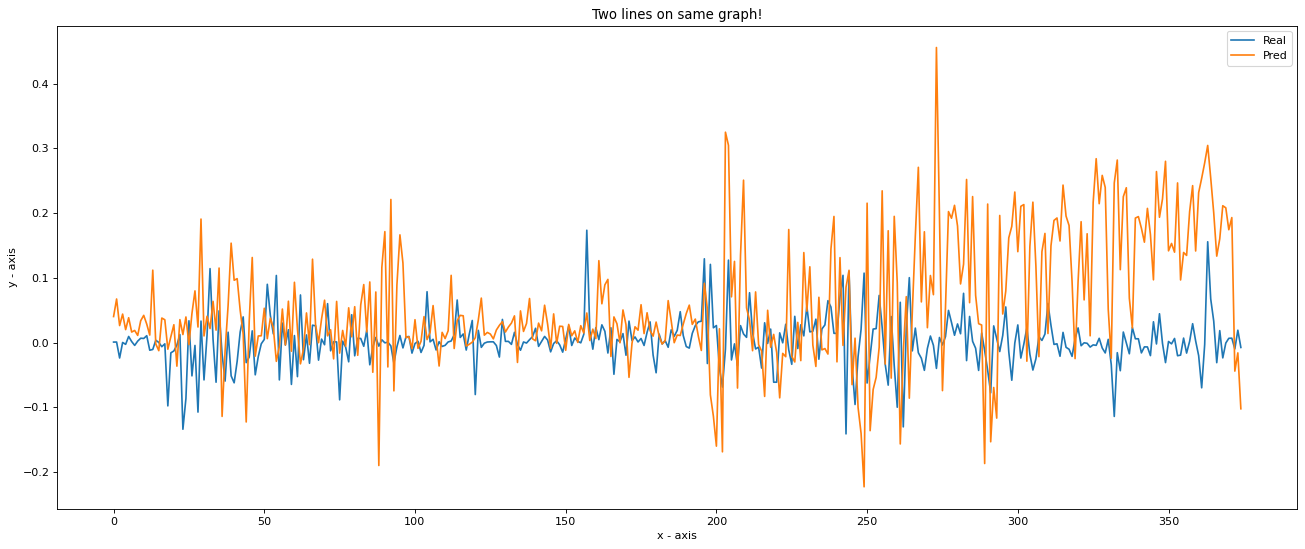

RMSE : 0.12088439132974417


In [40]:
figure(figsize=(20,8), dpi=80)

plt.plot(btc["1_Day_Price_Diff_Percent"][1500:1875].values, label = "Real")
plt.plot(pred2, label = "Pred")

plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Two lines on same graph!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()
rmse_(btc["1_Day_Price_Diff_Percent"][1500:1875].values,pred2)

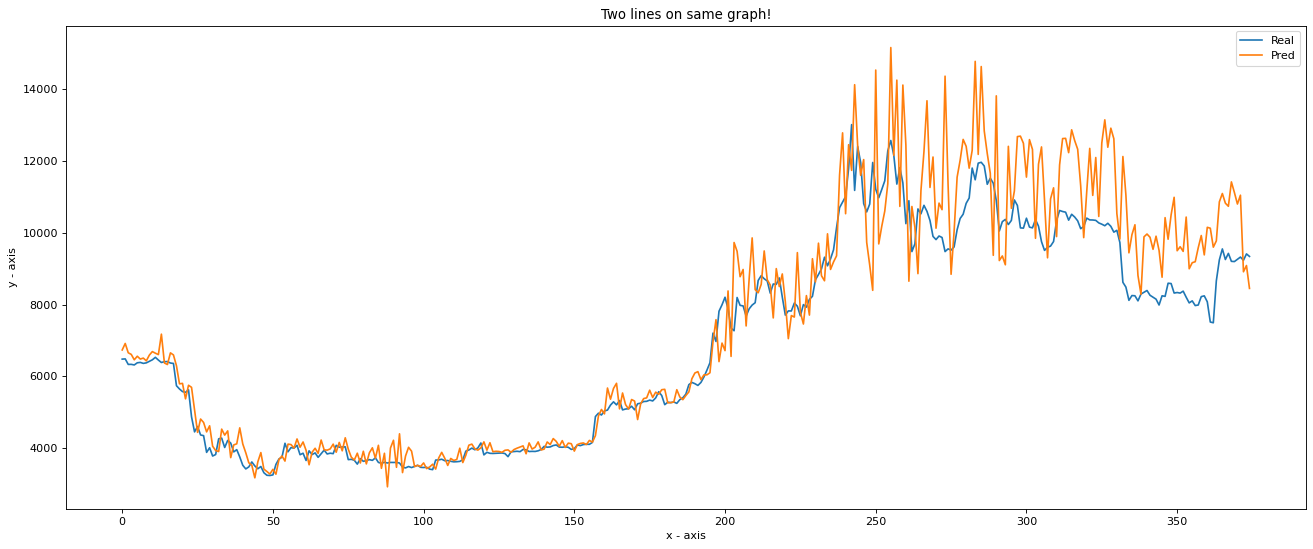

RMSE : 4368.275554767853


In [41]:
figure(figsize=(20,8), dpi=80)

pred_price = []
for num1, num2 in zip(pred2, btc["Close"][1500:1875].values):
	pred_price.append((num1 * num2) + num2)

plt.plot(btc["1_Day_Price"][1500:1875].values, label = "Real")
plt.plot(pred_price, label = "Pred")

plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Two lines on same graph!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()
rmse_(btc["1_Day_Price"][1500:1875].values,pred_price)

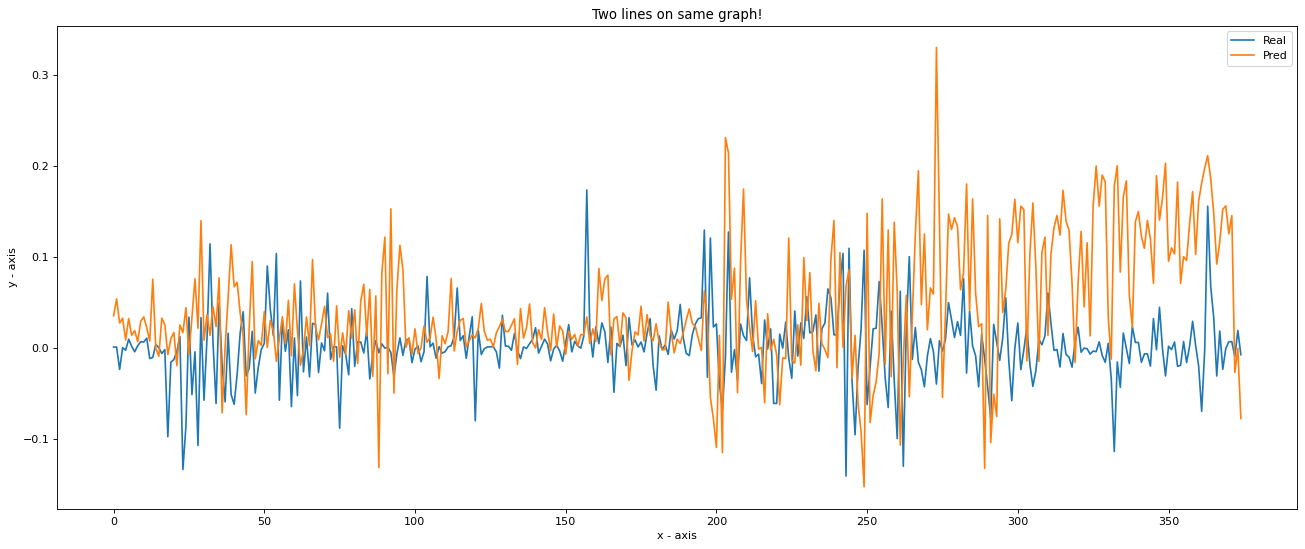

RMSE : 0.09062091853090998


In [42]:
mixm1m2 = pred1 * 0.3 + pred2 * 0.7

figure(figsize=(20,8), dpi=80)

plt.plot(btc["1_Day_Price_Diff_Percent"][1500:1875].values, label = "Real")
plt.plot(mixm1m2, label = "Pred")

plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Two lines on same graph!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()
rmse_(btc["1_Day_Price_Diff_Percent"][1500:1875].values,mixm1m2)